In [32]:
import os
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_google_genai import GoogleGenerativeAI
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from langchain_community.vectorstores import FAISS
import faiss
from langchain_community.docstore import InMemoryDocstore
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import PromptTemplate
from pydantic import Field
from typing import TypedDict
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel,Field
from langchain.output_parsers import PydanticOutputParser
import operator
from typing import Annotated,Sequence,Optional,Literal
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph,END
import random
from langchain_community.retrievers import TavilySearchAPIRetriever
from dotenv import load_dotenv
load_dotenv()
os.environ['HF_TOKEN']=os.getenv('HF_TOKEN')
os.environ['GOOGLE_API_KEY']=os.getenv('GOOGLE_API_KEY')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')


In [33]:
def configure_llm_model():
    model = GoogleGenerativeAI(model='gemini-1.5-flash')
    output = model.invoke("Hello")
    print(output)
    return model
def configure_embedding_model():
    embeddings = HuggingFaceEmbeddings(model="BAAI/bge-small-en")
    return embeddings
def load_text_document():
    loader = DirectoryLoader(path="../data",glob=['*.txt'],loader_cls=TextLoader)
    docs = loader.load()
    return docs
def split_docs(docs):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)
    doc_chunks = text_splitter.split_documents(docs)
    return doc_chunks
def create_db():
    embeddings = configure_embedding_model()
    index = faiss.IndexFlatIP(len(embeddings.embed_query('hello')))
    db = FAISS(embedding_function=embeddings,
               index=index,
               docstore=InMemoryDocstore(),
               index_to_docstore_id={})
    return db

In [34]:
docs = load_text_document()
doc_chunks = split_docs(docs)
embeddings = configure_embedding_model()
db = create_db()
db.from_documents(documents=doc_chunks, embedding=embeddings)
db.add_documents(doc_chunks)

['b3dd38b3-eb34-41c5-b974-5dc075df5388', '40e551c1-f264-4bd3-bce2-ef3e857c8c3f', 'd2ed7757-7985-41b5-9246-d8c488fc1f5f']

In [35]:
retriver = db.as_retriever(search_kwargs={'k':2})
retriver.invoke("Tell me about USA GDP?")

[Document(id='b3dd38b3-eb34-41c5-b974-5dc075df5388', metadata={'source': '..\\data\\usa.txt'}, page_content="Title: United States Gross Domestic Product (GDP) Overview\n\nThe Gross Domestic Product (GDP) of the United States is a key indicator of the country's economic performance. As of 2023, the nominal GDP of the U.S. was approximately $26.95 trillion, making it the largest economy in the world.\n\nGDP represents the total market value of all final goods and services produced in a country during a specific period. It is often measured quarterly and annually by the Bureau of Economic Analysis (BEA)."), Document(id='40e551c1-f264-4bd3-bce2-ef3e857c8c3f', metadata={'source': '..\\data\\usa.txt'}, page_content='Key Highlights:\n\n1947 GDP: $243.1 billion\n\n1980 GDP: $2.86 trillion\n\n2000 GDP: $10.25 trillion\n\n2010 GDP: $14.96 trillion\n\n2020 GDP (pandemic impact): $20.93 trillion\n\n2023 GDP: $26.95 trillion\n\nReal vs. Nominal GDP:\n\nNominal GDP is not adjusted for inflation and 

In [36]:
model = configure_llm_model()

Hello there! How can I help you today?


In [37]:
class TopicClassifierModel(BaseModel):
    Topic:str=Field(description="Topic selected")
    Reason:str=Field(description="Reason for selecting the Topic")
    
parser = PydanticOutputParser(pydantic_object=TopicClassifierModel)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Topic selected", "title": "Topic", "type": "string"}, "Reason": {"description": "Reason for selecting the Topic", "title": "Reason", "type": "string"}}, "required": ["Topic", "Reason"]}
```


In [38]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]
    selected_node: Optional[str]
    validation_passed:Optional[bool]

In [39]:
def format_docs(docs):
    return '\n\n'.join([doc.page_content for doc in docs])

def SUPERVISOR(state:AgentState):
    print("<<--SUPERVISOR-->>")
    print("Supervisor function triggered")
    template = """ You are a helpful supervisor oversees the given user question : {question} and classfies it into one of the below categories." \
    "['usa','not related','real time']" \
    "That is you check the given question/query and determine if the given question is related to GDP of USA or not related or something that requires real time web search inorder to answer"
    {format_instructions}"""
    prompt = PromptTemplate(template=template,
                            input_variables=['question'],
                            partial_variables={'format_instructions':parser.get_format_instructions}

    )
    chain = prompt | model | parser
    question = state['messages'][-1]
    
    response = chain.invoke(question)
    selected_topic = response.Topic
    node_map = {'usa':'rag','not related':'llm','real time':'web'}
    selected_node = node_map[selected_topic]

    print(response)
    print(selected_node)
    return {'messages':[response.Topic],
            'selected_node':selected_node,
            'validation_passed':None}

def LLM(state:AgentState):
    print("<<--LLM->>")
    question = state['messages'][0]
    template = """
                You are a helpful assistant in answering the user question in an accurate and precise manner. You answers will be factually correct.
                Usewr question : {question}                
            """
    prompt = PromptTemplate(template=template,
                            input_variables=['question'])
    chain = prompt | model | StrOutputParser()
    response = chain.invoke(question)
    print(response)
    return {'messages':[response]}

def RAG(state:AgentState):
    print("<<--RAG->>")
    question = state['messages'][0]
    template = """
                You are a helpful assistant in answering the user question in an accurate and precise manner based on the given context.
                context = {context}
                user question = {question}             
            """
    prompt = PromptTemplate(template=template,
                            input_variables=['question','context'])
    rag_chain = ({'context': retriver | format_docs, 'question':RunnablePassthrough()}
                 | prompt
                 | model
                 | StrOutputParser()
                 )
    response = rag_chain.invoke(question)
    print(response)
    return {'messages':[response]}

def WEB(state:AgentState):
    print("<<--WEB->>")
    print("WEB function triggered")
    question = state['messages'][0]
    from langchain_community.retrievers import TavilySearchAPIRetriever
    tavily_retriever = TavilySearchAPIRetriever(k=3)

    template = """Answer the question based only on the context provided.
        Context: {context}

        Question: {question}"""
    prompt = PromptTemplate(template=template,
                            input_variables=['question','context'])
    chain = (
            {"context": tavily_retriever | format_docs, "question": RunnablePassthrough()}
            | prompt
            | model
            | StrOutputParser()
            )

    response = chain.invoke(question)
    print("Tavily Search and LLM Reponse Generated")
    return {'messages':[response]}

def VALIDATOR(state: AgentState):
    print("<<--VALIDATOR-->>")
    question = state['messages'][0]
    answer = state['messages'][-1]

    # Ask the model to validate its own answer
    validation_prompt = PromptTemplate(
        template="""
        Given a user question and an answer, determine whether the answer is factually correct, relevant, and sufficient.

        Question: {question}
        Answer: {answer}

        Respond only with 'pass' or 'fail'.
        """,
        input_variables=['question', 'answer']
    )
    validation_chain = validation_prompt | model | StrOutputParser()
    result = validation_chain.invoke({"question": question, "answer": answer}).strip().lower()

    if result == "pass":
        print("Validation Passed by LLM.")
        return {'validation_passed': 'pass'}
    else:
        print("Validation Failed by LLM.")
        return {'validation_passed': 'fail'}

def route_with_selection(state:AgentState):
    return state['selected_node']
def route_with_validation(state:AgentState):
    return state['validation_passed']

In [40]:
workflow = StateGraph(AgentState)
workflow.add_node('supervisor',SUPERVISOR)
workflow.add_node('llm',LLM)
workflow.add_node('rag',RAG)
workflow.add_node('web',WEB)
workflow.add_node('validator',VALIDATOR)
workflow.set_entry_point('supervisor')

workflow.add_edge('llm','validator')
workflow.add_edge('rag','validator')
workflow.add_edge('web','validator')

workflow.add_conditional_edges('supervisor',
                               route_with_selection,
                               {
                                  'llm':'llm',
                                  'rag':'rag',
                                  'web':'web' 
                               })

workflow.add_conditional_edges('validator',
                               route_with_validation,
                               {
                                  'pass':END,
                                  'fail':'supervisor',
                               })

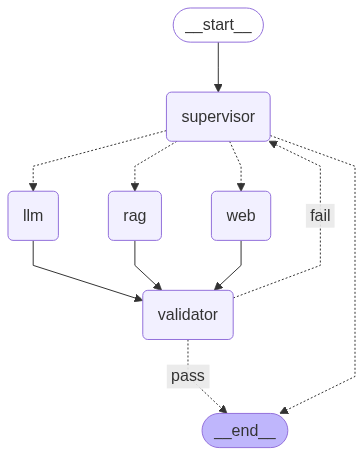

In [41]:
app = workflow.compile()
app

In [42]:
state_var = {'messages':["Tell me something about USA GDP?"]}

response = app.invoke(state_var)

<<--SUPERVISOR-->>
Supervisor function triggered
Topic='usa' Reason="The question explicitly asks about the USA's GDP."
rag
<<--RAG->>
The U.S. has the world's largest economy, with a nominal GDP of approximately $26.95 trillion in 2023.  This figure represents the total market value of all final goods and services produced within the U.S. in that year.  The GDP is tracked and reported by the Bureau of Economic Analysis (BEA), both quarterly and annually.  It's important to distinguish between nominal GDP (unadjusted for inflation) and real GDP (adjusted for inflation).  The GDP has grown significantly since 1947, when it was $243.1 billion.
<<--VALIDATOR-->>
Validation Passed by LLM.


In [43]:
import pprint
pprint.pprint(response['messages'][-1])

("The U.S. has the world's largest economy, with a nominal GDP of "
 'approximately $26.95 trillion in 2023.  This figure represents the total '
 'market value of all final goods and services produced within the U.S. in '
 'that year.  The GDP is tracked and reported by the Bureau of Economic '
 "Analysis (BEA), both quarterly and annually.  It's important to distinguish "
 'between nominal GDP (unadjusted for inflation) and real GDP (adjusted for '
 'inflation).  The GDP has grown significantly since 1947, when it was $243.1 '
 'billion.')


In [44]:
state_var = {'messages':["Tell me something about latest news?"]}

response = app.invoke(state_var)

pprint.pprint(response['messages'][-1])

<<--SUPERVISOR-->>
Supervisor function triggered
Topic='real time' Reason='The question asks for the latest news, which requires a real-time web search to provide a current and accurate answer.'
web
<<--WEB->>
WEB function triggered
Tavily Search and LLM Reponse Generated
<<--VALIDATOR-->>
Validation Failed by LLM.
<<--SUPERVISOR-->>
Supervisor function triggered
Topic='not related' Reason='The query describes a military conflict between Israel and Iran, which is not directly related to the GDP of the USA.'
llm
<<--LLM->>
Recent news is highly dynamic, so providing the *absolute* latest requires a real-time news feed.  However, I can give you a summary of some significant ongoing news themes as of October 26, 2023:

* **Global Politics:**  International relations remain tense in various regions.  Specific conflicts and diplomatic efforts are constantly evolving and require consulting current news sources for up-to-the-minute details.  Major themes often include geopolitical tensions, i

In [45]:
state_var = {'messages':["Tell me how are you feeling today?"]}

response = app.invoke(state_var)

pprint.pprint(response['messages'][-1])

<<--SUPERVISOR-->>
Supervisor function triggered
Topic='not related' Reason='The question "Tell me how are you feeling today?" is a personal inquiry about the speaker\'s emotional state.  It has no connection to the GDP of the USA or any other economic data.'
llm
<<--LLM->>
As a large language model, I don't experience emotions or feelings in the same way humans do.  I don't have a body or personal experiences that would generate feelings.  Therefore, I cannot tell you how I am feeling today.
<<--VALIDATOR-->>
Validation Passed by LLM.
("As a large language model, I don't experience emotions or feelings in the "
 "same way humans do.  I don't have a body or personal experiences that would "
 'generate feelings.  Therefore, I cannot tell you how I am feeling today.')
